In [144]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Union, Optional
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats

In [145]:
class OptimaOutput:
    def __init__(self, job_name: Union[str, Path],
                 optima_path: Optional[Union[str, Path]] = None):

        self.job_name = str(job_name)
        if optima_path == None:
            self.optima_path = Path("/home/nvme/Opt/outputs")
        self.job_folder = self.optima_path / job_name
        file_path = self.job_folder / "mechanismInfo.txt"
        try:
            with open(file_path, "r") as f:
                self.mech_info = f.read()
        except Exception as e:
            raise e

In [149]:
class OptimaMechtest(OptimaOutput):
    def __init__(self, job_name: Union[str, Path],
                 optima_path: Optional[Union[str, Path]] = None,
                 errf_type: Union[str, List[str]] = "default"):
        super().__init__(job_name, optima_path)

        self._errf_files = {
           "default": "errfValues",
           "data_series": "errfValues_by_data_series", 
           "points": "errfValues_by_points",
           "species": "errfValues_by_species"
            }
        
        if (self.job_folder / "debug").exists():
            self.all_data = {}
            for csv_data in (self.job_folder / "debug").glob("*.csv"):
                try:
                    self.all_data[csv_data.stem] = pd.read_csv(csv_data)
                except Exception as e:
                    print(e)

        if (self.job_folder / "mechTestResults_BCRN6.csv").exists():
            all_sheets_dP = pd.read_csv(self.job_folder / "mechTestResults_BCRN6.csv",  # dP as in the info in dataPoints
                                        header=None,
                                        delimiter=';',
                                        index_col=False,
                                        names=['xml', 'time_point', 'species', 'dP_val', 'sim_val'])
            self.get_the34(all_sheets_dP=all_sheets_dP)

        try:
            if isinstance(errf_type, str):
                file_name = self._errf_files.get(errf_type, "errfValues")
                self.errfValues = pd.read_csv(
                    self.job_folder / file_name,
                    header = 9,
                    delim_whitespace = True
                )
            else:
                self.errfValues = {}
                for e_type in errf_type:
                    file_name = self._errf_files.get(errf_type, "errfValues")
                    self.errfValues[e_type] = pd.read_csv(
                        self.job_folder / file_name,
                        header = 9,
                        delim_whitespace = True
                    )
                
            if (self.job_folder / "sigmas").is_file():
                self.sigmas = pd.read_csv(
                    self.job_folder / "sigmas",
                    skiprows = [0,2],
                    delim_whitespace = True
                )
        except Exception as e:
            raise e
        
    def get_the34(self, all_sheets_dP):
        self.xml_dP: dict[str: pd.DataFrame] = {}
        time_point = 0
        species = 'ilyen_species_tuti_nem_lesz'
        for idx, row in all_sheets_dP.iterrows():
            xml_name = row.xml
            sim_val = row.sim_val

            if row.species == species:
                time_point = time_point + 1
            else:
                species = row.species
                time_point = 1
            
            if xml_name not in self.xml_dP.keys():
                self.xml_dP[xml_name] = pd.DataFrame()  # Initialize inner dict
            self.xml_dP[xml_name].loc[time_point, species] = sim_val
            

In [150]:
class OptimaSensitivity(OptimaOutput):
    def __init__(self, job_name: Union[str, Path], optima_path: Optional[Union[str, Path]] = None):
        super().__init__(job_name, optima_path)
        try:
            self.reactionList = pd.read_csv(self.job_folder / "reactionList.txt",
                                            delim_whitespace = True
                                            )
            self.sensitivityResults = pd.read_csv(self.job_folder / "sensitivityResults",
                                                  header = 6,
                                                  delim_whitespace = True
                                            )
        except Exception as e:
            raise e
    def _calc_overal_impact(self, sigma, data_m):
        I = sigma * np.sqrt(1/(N_cond*N_tim)*s**2)
        return I
    def calc_normalised_sensitivity(self):
        return

In [155]:
mech = OptimaMechtest("20250123_BCRN_cor.opp")

stac_eq_df = pd.concat({k: v.iloc[-1] for k, v in mech.all_data.items()}, axis=1)
followed34 = pd.concat({k: v.iloc[-1] for k, v in xml_dP.items()}, axis=1)
df_basal = stac_eq_df.iloc[3:-1].T * 10e9
df_followed34 = followed34.T * 10e9             # igy nM-ben vannak
print(f"dimenziok: (xml_szam, species_szam)\nall:{df_basal.shape}\nfollowed:{df_followed34.shape}")

dimenziok: (xml_szam, species_szam)
all:(20, 83)
followed:(20, 34)


In [164]:
basal_cov = df_basal.cov()
followed34_cov = df_followed34.cov()
basal_corr = df_basal.corr()
followed34_corr = df_followed34.corr()
print(followed34_corr)

                 AC      AKTA      AMPK  ATG5  ATG5T      BCL2  BCL2_BAX  \
AC         1.00e+00  2.11e-01 -4.14e-02  0.13  -0.16 -8.38e-03  5.40e-02   
AKTA       2.11e-01  1.00e+00 -1.10e-01  0.20  -0.27  2.30e-01  2.24e-01   
AMPK      -4.14e-02 -1.10e-01  1.00e+00  0.18   0.32 -9.00e-02  2.96e-01   
ATG5       1.26e-01  2.00e-01  1.78e-01  1.00  -0.07  2.88e-01  2.88e-02   
ATG5T     -1.62e-01 -2.72e-01  3.25e-01 -0.07   1.00 -6.53e-01  1.21e-01   
BCL2      -8.38e-03  2.30e-01 -9.00e-02  0.29  -0.65  1.00e+00  1.67e-01   
BCL2_BAX   5.40e-02  2.24e-01  2.96e-01  0.03   0.12  1.67e-01  1.00e+00   
BCL2_PUMA -2.22e-01 -1.46e-01 -1.05e-01  0.06  -0.22  4.79e-01 -2.26e-02   
BEC1      -2.21e-01 -7.76e-02  9.68e-02  0.02   0.19 -4.38e-01 -2.84e-01   
BAX        3.03e-01  4.41e-01 -1.14e-01 -0.42   0.05 -4.36e-01 -1.62e-01   
BID        1.26e-02 -2.38e-01  1.81e-01 -0.07  -0.09  1.25e-01 -2.91e-01   
CA2ER      6.15e-01  2.06e-01 -3.05e-01  0.09  -0.07 -7.54e-02  2.52e-03   
CA2IC     -3

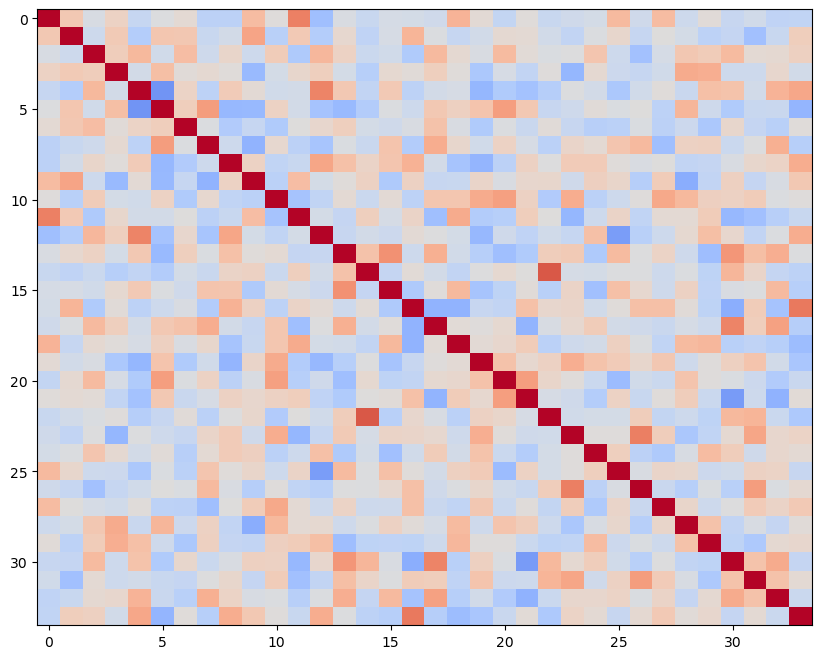

In [165]:
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 2)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(basal_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.savefig('test_all')
im = ax.imshow(followed34_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.savefig('test_followed34')
